In [37]:
import jax
import jax.numpy as jnp
from jax import grad, vmap
import optax
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import sobel
from scipy.ndimage import binary_erosion
import numpy as np
import pandas as pd

In [38]:
# 설정: 지구 좌표 크기
rows, cols = 60, 100

# 좌표 평면 생성
x_coords = jnp.linspace(0, cols - 1, cols)
y_coords = jnp.linspace(0, rows - 1, rows)

# 코드와 같이 제출된 사진 중 '대륙사진2'사진을 이용합니다.
image_path = '대륙사진2.png'

In [39]:
# 아래에서 불러오는 데이터들은 코드와 같이 보내드렸습니다.
# 이 데이터들은 marine.copernicus.eu에서 가져와서 저희가 자체적으로 이미 1차적으로 전처리를 한 상태이며,
# 2022년부터 2024년까지의 해수온도, 빙하량, 해수밀도 데이터입니다.

# 이미 진행된 1차 전처리 과정은 아래와 같습니다.
# 원본 데이터는 크기가 너무 커서(한 데이터 당 800만개) 데이터를 이미지화 시킨 다음에 resize를 해서 데이터 수를 줄였습니다.(가상 데이터와 같은 사이즈로 resize)
# 또한 빙하량은 해당 위치에서 단위 면적당 눈이 덮인 부분의 면적 비율 x 빙하량의 두께로 계산했습니다. 
# 그리고 대륙 지역의 온도는 nan값으로 되어 있어 'The Berkeley Earth Land/Ocean Temperature Record'를 참고하여 해수 온도로 기반으로 채워넣었습니다.

T_initial = pd.read_csv('Temperature_array_22.csv', index_col=0, header=0)
B_initial = pd.read_csv('Glacier_array_22.csv', index_col=0, header=0)
rho_initial = pd.read_csv('Density_array_22.csv', index_col=0, header=0)

T_1 = pd.read_csv('Temperature_array_23.csv', index_col=0, header=0)
B_1 = pd.read_csv('Glacier_array_23.csv', index_col=0, header=0)
rho_1 = pd.read_csv('Density_array_23.csv', index_col=0, header=0)

T_2 = pd.read_csv('Temperature_array_24.csv', index_col=0, header=0)
B_2 = pd.read_csv('Glacier_array_24.csv', index_col=0, header=0)
rho_2 = pd.read_csv('Density_array_24.csv', index_col=0, header=0)

In [40]:
# 데이터를 jnp화 시킵니다.
def data_preprocessing1(data):
    data = data.to_numpy()
    data = np.flipud(data)
    data = jnp.array(data)
    return data

In [41]:
# 온도, 빙하량, 밀도마다 값의 크기가 달라서 이를 맞추기 위해 간단히 normalization을 해줍니다.
def normalize_matrices(matrix1, matrix2, matrix3):

    # 3개의 매트릭스를 하나로 합침
    combined_matrix = np.concatenate([matrix1.flatten(), matrix2.flatten(), matrix3.flatten()])

    # 전체 최대값 계산
    max_value = np.max(combined_matrix)

    # 정규화 (최대값으로 나누고 6을 곱함)
    normalized_combined = (combined_matrix / max_value) * 6

    # 다시 매트릭스 3개로 나누기
    matrix1_normalized = normalized_combined[:matrix1.size].reshape(matrix1.shape)
    matrix2_normalized = normalized_combined[matrix1.size:matrix1.size + matrix2.size].reshape(matrix2.shape)
    matrix3_normalized = normalized_combined[matrix1.size + matrix2.size:].reshape(matrix3.shape)

    return matrix1_normalized, matrix2_normalized, matrix3_normalized

In [42]:
T_initial = data_preprocessing1(T_initial)
B_initial = data_preprocessing1(B_initial)
rho_initial = data_preprocessing1(rho_initial)

T_1 = data_preprocessing1(T_1)
B_1 = data_preprocessing1(B_1)
rho_1 = data_preprocessing1(rho_1)

T_2 = data_preprocessing1(T_2)
B_2 = data_preprocessing1(B_2)
rho_2 = data_preprocessing1(rho_2)

In [43]:
T_initial, T_1, T_2 = normalize_matrices(T_initial, T_1, T_2)
B_initial, B_1, B_2 = normalize_matrices(B_initial, B_1, B_2)
rho_initial, rho_1, rho_2 = normalize_matrices(rho_initial, rho_1, rho_2)

In [44]:
# 관측 데이터를 세계지도와 함께 시각화하는 코드입니다.
def visualize_with_map_faint(T_initial, B_initial, rho_initial, map_path, t):

    # Load, flip, and resize the world map
    world_map = Image.open(map_path).convert("RGB")
    world_map = world_map.transpose(Image.FLIP_TOP_BOTTOM)  # Flip the image vertically
    world_map = world_map.resize((T_initial.shape[1], T_initial.shape[0]))  # Resize to match the data dimensions

    # Convert the flipped world map to a NumPy array
    world_map_array = np.array(world_map)

    # Create a figure with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Visualize T_initial
    axes[0].imshow(world_map_array, extent=[0, T_initial.shape[1], 0, T_initial.shape[0]], origin='lower', alpha=0.5)  # Adjust alpha for faint effect
    im1 = axes[0].imshow(T_initial, cmap='coolwarm', alpha=0.8, extent=[0, T_initial.shape[1], 0, T_initial.shape[0]], origin='lower')
    cbar1 = fig.colorbar(im1, ax=axes[0], orientation='vertical', pad=0.1)
    axes[0].set_title(f"Temperature Initial Conditions (t = {t})")  # Add time to the title
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")

    # Visualize B_initial
    axes[1].imshow(world_map_array, extent=[0, B_initial.shape[1], 0, B_initial.shape[0]], origin='lower', alpha=0.5)  # Adjust alpha for faint effect
    im2 = axes[1].imshow(B_initial, cmap='Blues', alpha=0.8, extent=[0, B_initial.shape[1], 0, B_initial.shape[0]], origin='lower')
    cbar2 = fig.colorbar(im2, ax=axes[1], orientation='vertical', pad=0.1)
    axes[1].set_title(f"Glacier Initial Conditions (t = {t})")  # Add time to the title
    axes[1].set_xlabel("Longitude")
    axes[1].set_ylabel("Latitude")

    # Visualize rho_initial
    axes[2].imshow(world_map_array, extent=[0, rho_initial.shape[1], 0, rho_initial.shape[0]], origin='lower', alpha=0.5)  # Adjust alpha for faint effect
    im3 = axes[2].imshow(rho_initial, cmap='viridis', alpha=0.8, extent=[0, rho_initial.shape[1], 0, rho_initial.shape[0]], origin='lower')
    cbar3 = fig.colorbar(im3, ax=axes[2], orientation='vertical', pad=0.1)
    axes[2].set_title(f"Density Initial Conditions (t = {t})")  # Add time to the title
    axes[2].set_xlabel("Longitude")
    axes[2].set_ylabel("Latitude")

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

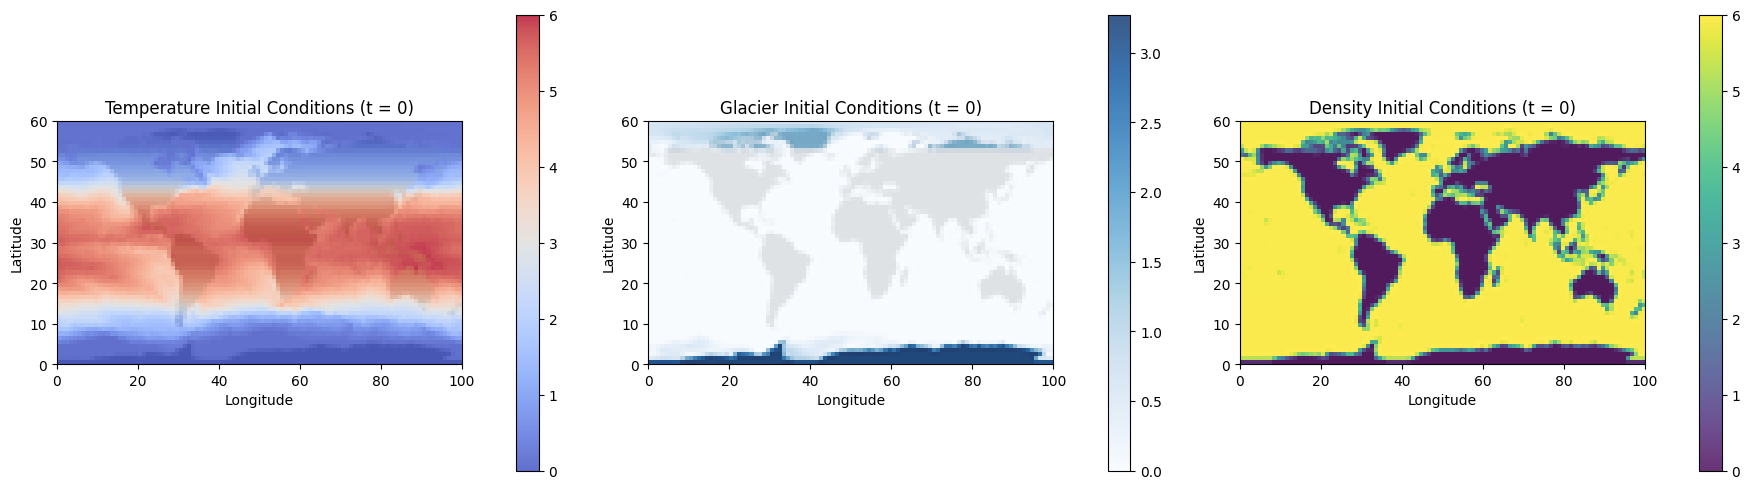

In [45]:
visualize_with_map_faint(T_initial, B_initial, rho_initial, image_path, 0)

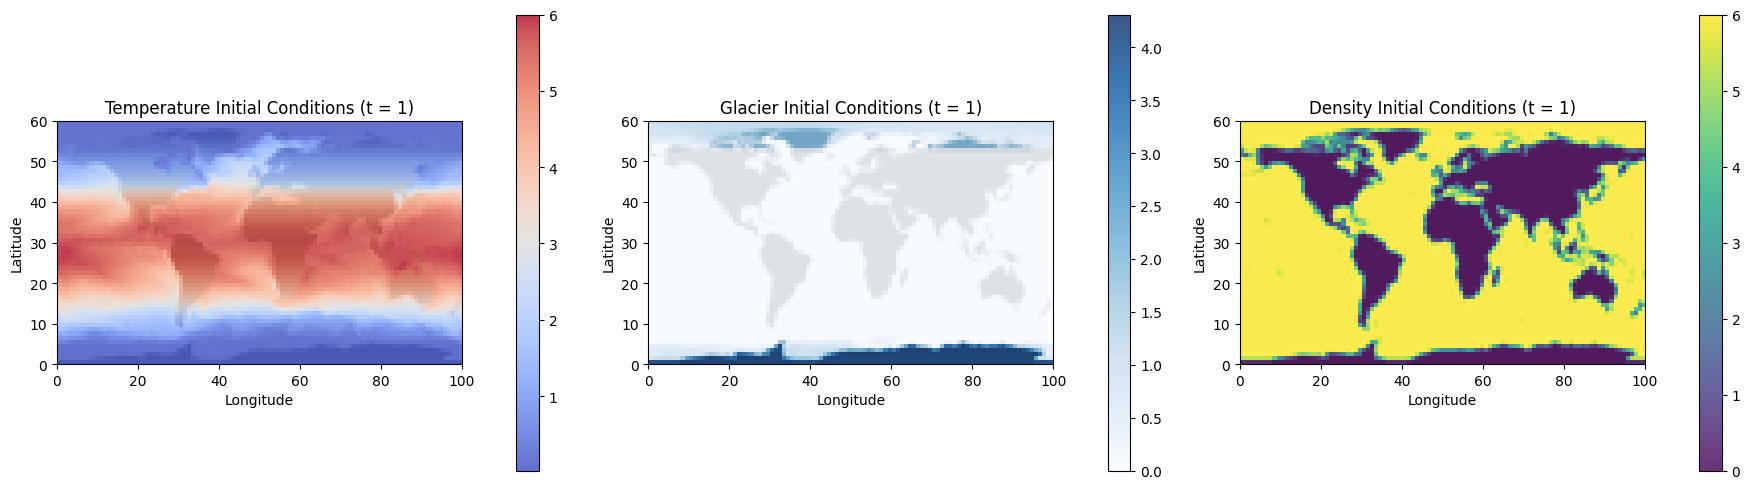

In [46]:
visualize_with_map_faint(T_1, B_1, rho_1, image_path, 1)

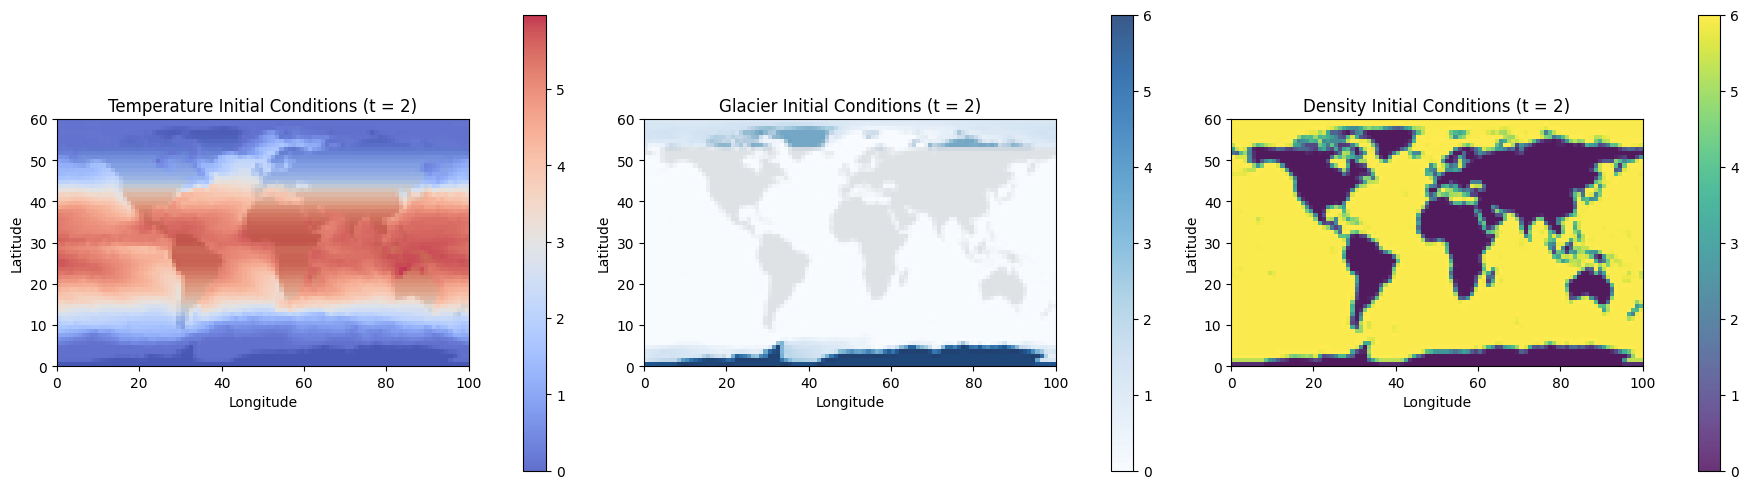

In [47]:
visualize_with_map_faint(T_2, B_2, rho_2, image_path, 2)

In [48]:
# 관측데이터를 하나로 모으는 코드입니다.

# txy 관측값 생성
t_0 = jnp.zeros((rows * cols, 1))  # t = 0
t_1 = jnp.ones((rows * cols, 1))  # t = 1
t_2 = jnp.full((rows * cols, 1), 2)  # t = 2

x, y = jnp.meshgrid(x_coords, y_coords)
x_flat = x.flatten()[:, jnp.newaxis]
y_flat = y.flatten()[:, jnp.newaxis]

# Combine t, x, y for each time step
txy_0 = jnp.hstack([t_0, x_flat, y_flat])  # (n, 3) for t = 0
txy_1 = jnp.hstack([t_1, x_flat, y_flat])  # (n, 3) for t = 1
txy_2 = jnp.hstack([t_2, x_flat, y_flat])  # (n, 3) for t = 2

# Combine all txy data
txy = jnp.vstack([txy_0, txy_1, txy_2])

# Combine targets for each time step
targets_0 = jnp.hstack([
    T_initial.flatten()[:, jnp.newaxis],
    B_initial.flatten()[:, jnp.newaxis],
    rho_initial.flatten()[:, jnp.newaxis],
])

targets_1 = jnp.hstack([
    T_1.flatten()[:, jnp.newaxis],
    B_1.flatten()[:, jnp.newaxis],
    rho_1.flatten()[:, jnp.newaxis],
])

targets_2 = jnp.hstack([
    T_2.flatten()[:, jnp.newaxis],
    B_2.flatten()[:, jnp.newaxis],
    rho_2.flatten()[:, jnp.newaxis],
])

# Combine all targets
targets = jnp.vstack([targets_0, targets_1, targets_2])

In [49]:
print(txy.shape)
print(targets.shape)

(18000, 3)
(18000, 3)


In [50]:
# MLP 클래스 정의
class MLP:
    def __init__(self, features, activation=jnp.tanh):
        self.features = features
        self.activation = activation

    def init(self, key):
        layer_keys = jax.random.split(key, len(self.features) - 1)
        params = []
        for k, in_dim, out_dim in zip(layer_keys, self.features[:-1], self.features[1:]):
            params.append({
                "bias": jnp.zeros(out_dim),
                "kernel": jax.random.normal(k, shape=(in_dim, out_dim)) * jnp.sqrt(1 / in_dim),
            })
        return params

    def apply(self, params, x):
        for i, layer in enumerate(params):
            x = x @ layer["kernel"] + layer["bias"]
            if i < len(params) - 1:
                x = self.activation(x)
        return x

In [51]:
# PINN 모델 정의
model = MLP([3, 64, 64, 3])  # 입력: (t, x, y), 출력: (T, B, rho)

In [52]:
def apply_mlp_model(mlp_params, txy):
    if txy.ndim == 1:
        txy = txy[None, :]  # (1, 3)
    # 디버깅을 위한 출력
    elif txy.ndim == 2 and txy.shape[1] != 3:
        raise ValueError(f"Expected shape (n, 3), got {txy.shape}")
    return model.apply(mlp_params, txy)

In [53]:
# 손실 함수 정의
def mlp_model_loss(params, txy, targets):
    preds = apply_mlp_model(params["mlp_params"], txy)
    return jnp.mean((preds - targets) ** 2)

In [54]:
def compute_laplacian(mlp_params, txy):
    def single_laplacian(txy_single):
        # 모델 출력의 첫 번째 값 (온도 T)에 대해 라플라시안 계산
        def T_model(txy_input):
            return apply_mlp_model(mlp_params, txy_input[None, :])[0, 0]  # 온도 T 값만 반환

        # x 방향 2차 미분
        d2T_dx2 = grad(lambda txy: grad(T_model)(txy)[1])(txy_single)[1]
        # y 방향 2차 미분
        d2T_dy2 = grad(lambda txy: grad(T_model)(txy)[2])(txy_single)[2]

        # 라플라시안은 두 방향 2차 미분의 합
        return d2T_dx2 + d2T_dy2  # 스칼라 값 반환

    # 모든 샘플에 대해 single_laplacian 적용
    return vmap(single_laplacian)(txy)

In [55]:
# 저희가 모델링한 미분방정식 시스템의 코드입니다.
def pde(params, txy):
    mlp_params = params["mlp_params"]
    rho_initial = params["rho_initial_collocation"]  # 초기 밀도 저장

    # 모델 예측
    preds = apply_mlp_model(mlp_params, txy)
    T, B, rho = preds[:, 0], preds[:, 1], preds[:, 2]

    # 시간에 대한 편미분 계산
    T_t = vmap(lambda txy: grad(lambda txy: apply_mlp_model(mlp_params, txy[None, :])[0, 0])(txy)[0])(txy)
    B_t = vmap(lambda txy: grad(lambda txy: apply_mlp_model(mlp_params, txy[None, :])[0, 1])(txy)[0])(txy)
    rho_t = vmap(lambda txy: grad(lambda txy: apply_mlp_model(mlp_params, txy[None, :])[0, 2])(txy)[0])(txy)

    # 라플라시안 계산
    laplacian_T = compute_laplacian(mlp_params, txy)

    # 물리적 상수 Broadcasting
    D = params["pde_params"]["D"] * jnp.ones_like(T)  # 열 전달 계수
    C0 = params["pde_params"]["C0"] * jnp.ones_like(T)  # 초기 열 전달 계수
    k3 = params["pde_params"]["k3"]  # 밀도 변화 계수

    # C(x, y, t) 계산
    C = C0 - k3 * jnp.abs(rho - rho_initial)

    # G(t) 계산 (지구온난화와 태양복사에너지에 따른 온도 증가 정도, 매년 external_force 만큼 증가한다는 가정)
    t = txy[:, 0]  # txy에서 시간(t) 추출
    G = params["external_force"] * t  # G(t) = 0.02 * t

    k1 = params["pde_params"]["k1"] * jnp.ones_like(B)  # 빙하량 변화 계수
    k2 = params["pde_params"]["k2"] * jnp.ones_like(rho)  # 밀도 변화 계수
    Tm = params["pde_params"]["Tm"] * jnp.ones_like(T)  # 임계 온도

    # Shape 출력 디버깅
    print(f"T_t.shape: {T_t.shape}, laplacian_T.shape: {laplacian_T.shape}, C.shape: {C.shape}")

    # PDE 계산 (오차 계산)                       # 우리가 모델링한 식
    eq1 = T_t - D * laplacian_T - C * T - G     #  T_t =  D * laplacian_T + C * T + G(t), where C = C0 - k3*abs(rho-rho_0)
    eq2 = B_t + k1 * (T - Tm)                   #  B_t = - k1 * (T - Tm)
    eq3 = rho_t - k2 * B_t                      #  rho_t = k2 * B_t

    return eq1, eq2, eq3

In [56]:
def pde_loss(params, txy):
    eq1, eq2, eq3 = pde(params, txy)
    # PDE 오차 제곱 계산
    loss_eq1 = jnp.mean(eq1 ** 2)
    loss_eq2 = jnp.mean(eq2 ** 2)
    loss_eq3 = jnp.mean(eq3 ** 2)
    return loss_eq1 + loss_eq2 + loss_eq3

In [57]:
def pinn_loss(params, txy, targets, txy_collocation, data_weight, physics_weight):
    data_loss = mlp_model_loss(params, txy, targets)  # 관측 data 오차
    physics_loss = pde_loss(params, txy_collocation)  # PDE 오차
    total_loss = data_weight * data_loss + physics_weight * physics_loss
    return total_loss, (data_loss, physics_loss)

In [58]:
# 학습 루프 정의
@jax.jit
def pinn_step(params, txy, targets, txy_collocation, data_weight, physics_weight, opt_state):
    # `value_and_grad` 호출
    (loss, aux_data), loss_grad = jax.value_and_grad(pinn_loss, has_aux=True)(params, txy, targets, txy_collocation, data_weight, physics_weight)
    updates, opt_state = optimizer.update(loss_grad, opt_state)
    params = optax.apply_updates(params, updates)
    data_loss, physics_loss = aux_data  # 보조 데이터 unpack
    return params, opt_state, data_loss, physics_loss

In [59]:
# collocation data를 만드는 함수입니다.
def generate_collocation_data(num_points, rows, cols, rho_initial, t_min=0, t_max=100):
    key = jax.random.PRNGKey(42)

    # 전체 좌표 생성
    all_coords = jnp.array([(row, col) for row in range(rows) for col in range(cols)])
    n_total_points = all_coords.shape[0]

    if num_points > n_total_points * (t_max - t_min):
        raise ValueError(
            f"Requested num_points={num_points} exceeds maximum possible unique collocation points with given t range "
            f"and total coordinates ({n_total_points * (t_max - t_min)})."
        )

    # t 값별로 필요한 개수 계산
    t_values_per_t = num_points // (t_max - t_min)  # t 값별로 필요한 개수
    t_remainder = num_points % (t_max - t_min)  # 분배 후 남은 개수

    collocation_data_list = []
    rho_initial_list = []

    for t in range(t_min, t_max):
        # t 값에 대해 (x, y) 좌표 샘플링
        num_samples = t_values_per_t + (1 if t_remainder > 0 else 0)
        t_remainder -= 1 if t_remainder > 0 else 0

        # 전체 좌표에서 (x, y)를 샘플링 (중복 허용하지 않음)
        selected_indices = jax.random.choice(
            key, n_total_points, shape=(num_samples,), replace=False
        )
        selected_coords = all_coords[selected_indices]

        y_coords = selected_coords[:, 0]  # Row
        x_coords = selected_coords[:, 1]  # Col

        # t 값 생성
        t_values = jnp.full((len(x_coords), 1), t, dtype=jnp.float32)

        # 초기 밀도 가져오기
        rho_values = rho_initial[y_coords, x_coords].astype(jnp.float32)

        # Collocation 데이터 및 초기 밀도 값 저장
        collocation_data = jnp.hstack([t_values, x_coords[:, None], y_coords[:, None]])
        collocation_data_list.append(collocation_data)
        rho_initial_list.append(rho_values)

    # 모든 t 값에 대해 생성된 데이터를 하나의 배열로 병합
    collocation_data = jnp.vstack(collocation_data_list)
    rho_initial_collocation = jnp.concatenate(rho_initial_list)

    return collocation_data, rho_initial_collocation

In [60]:
num_points = 60000
txy_collocation, rho_initial_collocation = generate_collocation_data(
    num_points=num_points,
    rows=rows,
    cols=cols,
    rho_initial=rho_initial,
    t_min=0,
    t_max=60,
)

print(f"Collocation Data Shape: {txy_collocation.shape}")
print(f"rho_initial_collocation Shape: {rho_initial_collocation.shape}")
print(f"Sample Collocation Data:\n{txy_collocation[:5]}")
print(f"Sample rho_initial_collocation:\n{rho_initial_collocation[:5]}")

Collocation Data Shape: (60000, 3)
rho_initial_collocation Shape: (60000,)
Sample Collocation Data:
[[ 0.  8. 49.]
 [ 0. 62. 33.]
 [ 0. 74. 19.]
 [ 0. 71. 17.]
 [ 0. 17. 16.]]
Sample rho_initial_collocation:
[2.5882354 0.5647059 5.952941  5.9764705 5.9764705]


In [61]:
# pde 계수 초기화
# D와 C0는 실제 해수의 열 전도도를 바탕으로 값을 넣었습니다.(0.6~07)

key = jax.random.PRNGKey(0)
mlp_params = model.init(key)
pde_params = {
    #  T_t =  D * laplacian_T + C * T + G(t), where C = C0 - k3*abs(rho-rho_0)
    #  B_t = - k1 * (T - Tm)
    #  rho_t = k2 * B_t

    "D": 0.7,   # 열 전달 계수 (diffusion 계수, 현재 위치에서 다른 위치로 확산)
    "C0": 0.7,   # 초기 열 전달 계수 (다른 위치들에서 현재 위치로 들어오는)
    "k3": 0.6,   # 밀도 변화 계수 (밀도 변화가 열전달계수에 얼마나 많은 영향을 미치나, 컨베이어 벨트가 얼마나 망가지냐)
    "k1": 0.5,   # 빙하량 변화 계수 (온도가 증가할수록 빙하가 얼마나 빨리 녹을 것인지)
    "k2": 0.5,   # 밀도 변화 계수 (빙하가 녹음에 따라 해수 밀도가 얼마나 빨리 변할 것인지)
    "Tm": 0.0,   # 임계 온도 (빙하가 안정적으로 유지되는 임계온도)
}

params = {
    "mlp_params": mlp_params,
    "pde_params": pde_params,
    "external_force": 1.0,
    "rho_initial_collocation": rho_initial_collocation,  # Collocation 데이터에 매핑된 초기 밀도
}

In [62]:
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

In [63]:
# 학습
for epoch in range(20000):
    params, opt_state, data_loss, physics_loss = pinn_step(params, txy, targets, txy_collocation, 10000, 1, opt_state)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Data Loss: {data_loss}, Physics Loss: {physics_loss}")

T_t.shape: (60000,), laplacian_T.shape: (60000,), C.shape: (60000,)
Epoch 0, Data Loss: 10.384050369262695, Physics Loss: 1147.9931640625
T_t.shape: (60000,), laplacian_T.shape: (60000,), C.shape: (60000,)
T_t.shape: (60000,), laplacian_T.shape: (60000,), C.shape: (60000,)
Epoch 100, Data Loss: 2.8591458797454834, Physics Loss: 853.2965087890625
Epoch 200, Data Loss: 2.4704108238220215, Physics Loss: 632.3308715820312
Epoch 300, Data Loss: 2.335110664367676, Physics Loss: 373.6829528808594
Epoch 400, Data Loss: 2.128286123275757, Physics Loss: 146.58135986328125
Epoch 500, Data Loss: 1.9277435541152954, Physics Loss: 87.67488861083984
Epoch 600, Data Loss: 1.7044597864151, Physics Loss: 61.02360534667969
Epoch 700, Data Loss: 1.4821913242340088, Physics Loss: 48.99827194213867
Epoch 800, Data Loss: 1.3813891410827637, Physics Loss: 39.8850212097168
Epoch 900, Data Loss: 1.336158275604248, Physics Loss: 33.71855545043945
Epoch 1000, Data Loss: 1.2962398529052734, Physics Loss: 29.039541

In [64]:
# 특정 시점의 (t, x, y)에 대해 모든 변수(T, B, rho)를 예측하는 함수
def predict_variables_at_t(params, t, rows, cols, x_coords, y_coords):
    """
    특정 시간 t에서 지구의 모든 (x, y) 좌표에서의 T, B, rho를 예측.
    """
    t_fixed = jnp.full((rows * cols, 1), t)  # t 값을 고정
    x, y = jnp.meshgrid(x_coords, y_coords)  # 좌표 생성
    x_flat = x.flatten()[:, jnp.newaxis]
    y_flat = y.flatten()[:, jnp.newaxis]
    txy = jnp.hstack([t_fixed, x_flat, y_flat])  # (t, x, y) 입력 생성

    # MLP 모델로 예측 수행
    preds = apply_mlp_model(params["mlp_params"], txy)
    T, B, rho = preds[:, 0], preds[:, 1], preds[:, 2]  # 각 변수 분리
    return T.reshape(rows, cols), B.reshape(rows, cols), rho.reshape(rows, cols)

In [65]:
# 예측한 값들을 세계지도와 함께 시각화하는 코드
def plot_variables_with_map(T_matrix, B_matrix, rho_matrix, t, x_coords, y_coords, map_path):
    """
    온도, 빙하량, 밀도를 대륙 사진과 함께 시각화.
    """
    # Load, flip, and resize the world map
    world_map = Image.open(map_path).convert("RGB")
    world_map = world_map.transpose(Image.FLIP_TOP_BOTTOM)  # Flip the image vertically
    world_map = world_map.resize((T_matrix.shape[1], T_matrix.shape[0]))  # Resize to match data dimensions

    # Convert the flipped world map to a NumPy array
    world_map_array = np.array(world_map)

    # Create a figure with 1 row and 3 columns
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    # 색상 범위 고정
    vmin, vmax = 0, 6

    # 온도 시각화
    axs[0].imshow(world_map_array, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]], origin='lower', alpha=0.5)
    im1 = axs[0].imshow(T_matrix, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                        origin='lower', cmap='coolwarm', alpha=0.8, vmin=vmin, vmax=vmax)
    axs[0].set_title(f"Temperature (T) at t = {t}")
    axs[0].set_xlabel("Longitude (x)")
    axs[0].set_ylabel("Latitude (y)")
    fig.colorbar(im1, ax=axs[0], orientation='vertical', label='Temperature (°C)')

    # 빙하량 시각화
    axs[1].imshow(world_map_array, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]], origin='lower', alpha=0.5)
    im2 = axs[1].imshow(B_matrix, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                        origin='lower', cmap='Blues', alpha=0.8, vmin=vmin, vmax=vmax)
    axs[1].set_title(f"Glacier Volume (B) at t = {t}")
    axs[1].set_xlabel("Longitude (x)")
    axs[1].set_ylabel("Latitude (y)")
    fig.colorbar(im2, ax=axs[1], orientation='vertical', label='Glacier Volume')

    # 밀도 시각화
    axs[2].imshow(world_map_array, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]], origin='lower', alpha=0.5)
    im3 = axs[2].imshow(rho_matrix, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                        origin='lower', cmap='viridis', alpha=0.8, vmin=vmin, vmax=vmax)
    axs[2].set_title(f"Density (ρ) at t = {t}")
    axs[2].set_xlabel("Longitude (x)")
    axs[2].set_ylabel("Latitude (y)")
    fig.colorbar(im3, ax=axs[2], orientation='vertical', label='Density')

    plt.tight_layout()
    plt.show()

# 특정 시간 t에서 예측 및 시각화 수행
def visualize_at_t_with_map(params, t, rows, cols, x_coords, y_coords, map_path):
    """
    특정 시간 t에서 지구 대륙 사진과 함께 변수(T, B, rho)를 시각화.
    """
    T_matrix, B_matrix, rho_matrix = predict_variables_at_t(params, t, rows, cols, x_coords, y_coords)
    plot_variables_with_map(T_matrix, B_matrix, rho_matrix, t, x_coords, y_coords, map_path)

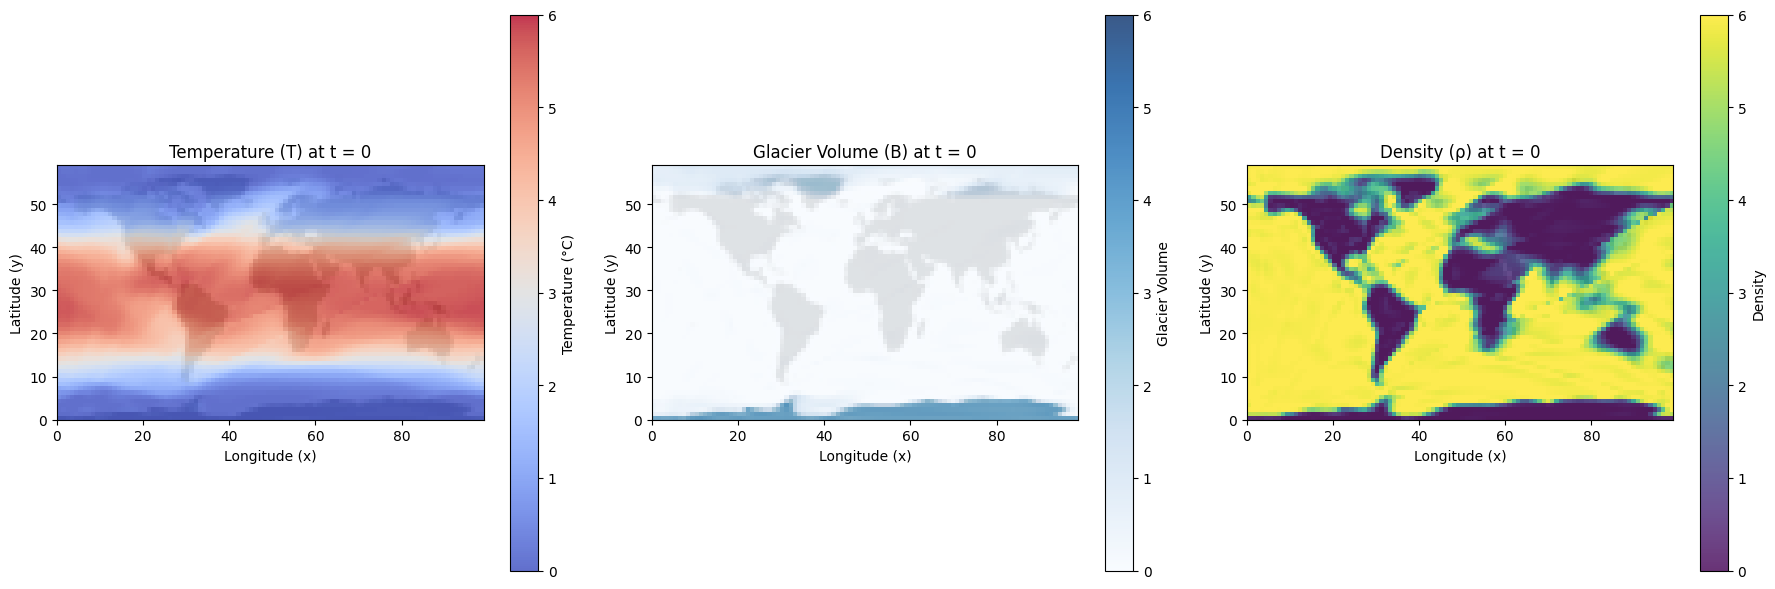

In [66]:
visualize_at_t_with_map(params, t=0, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

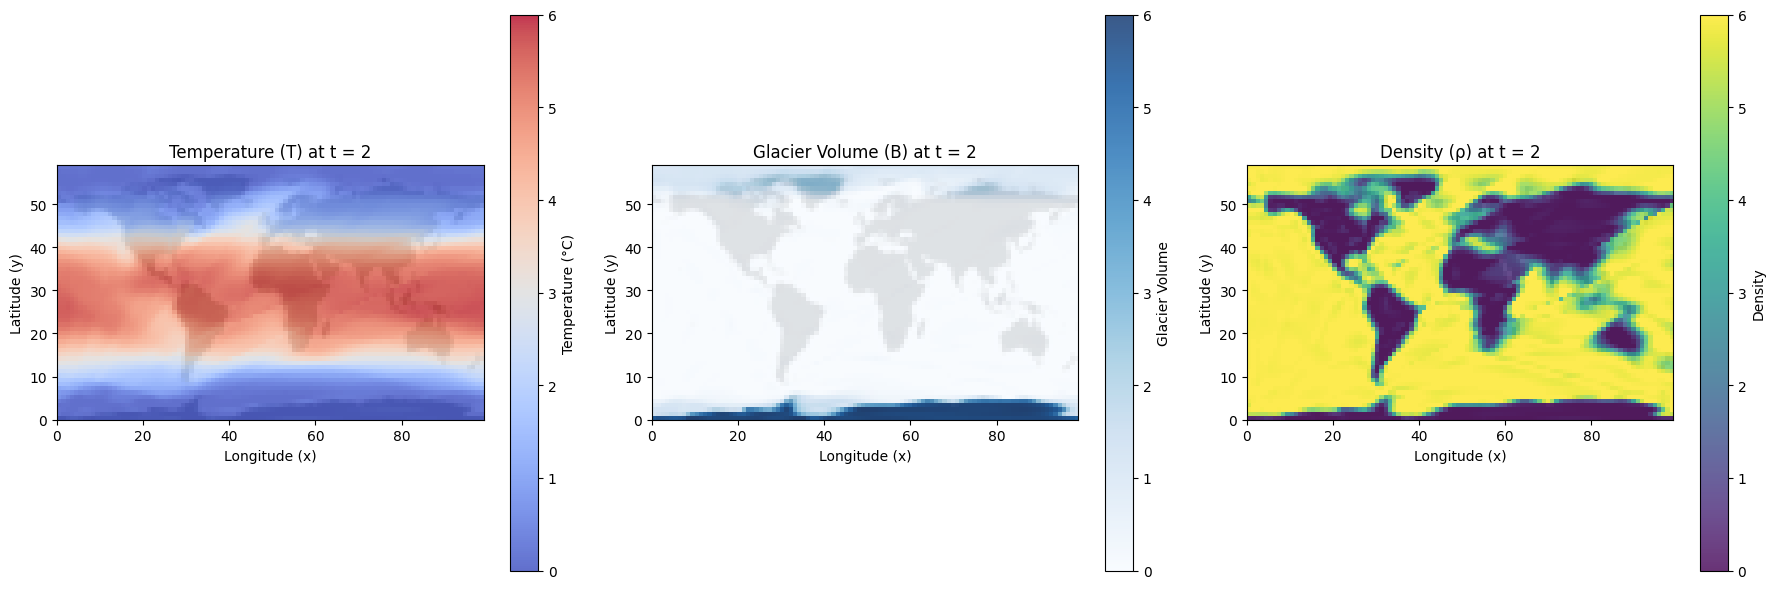

In [67]:
visualize_at_t_with_map(params, t=2, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

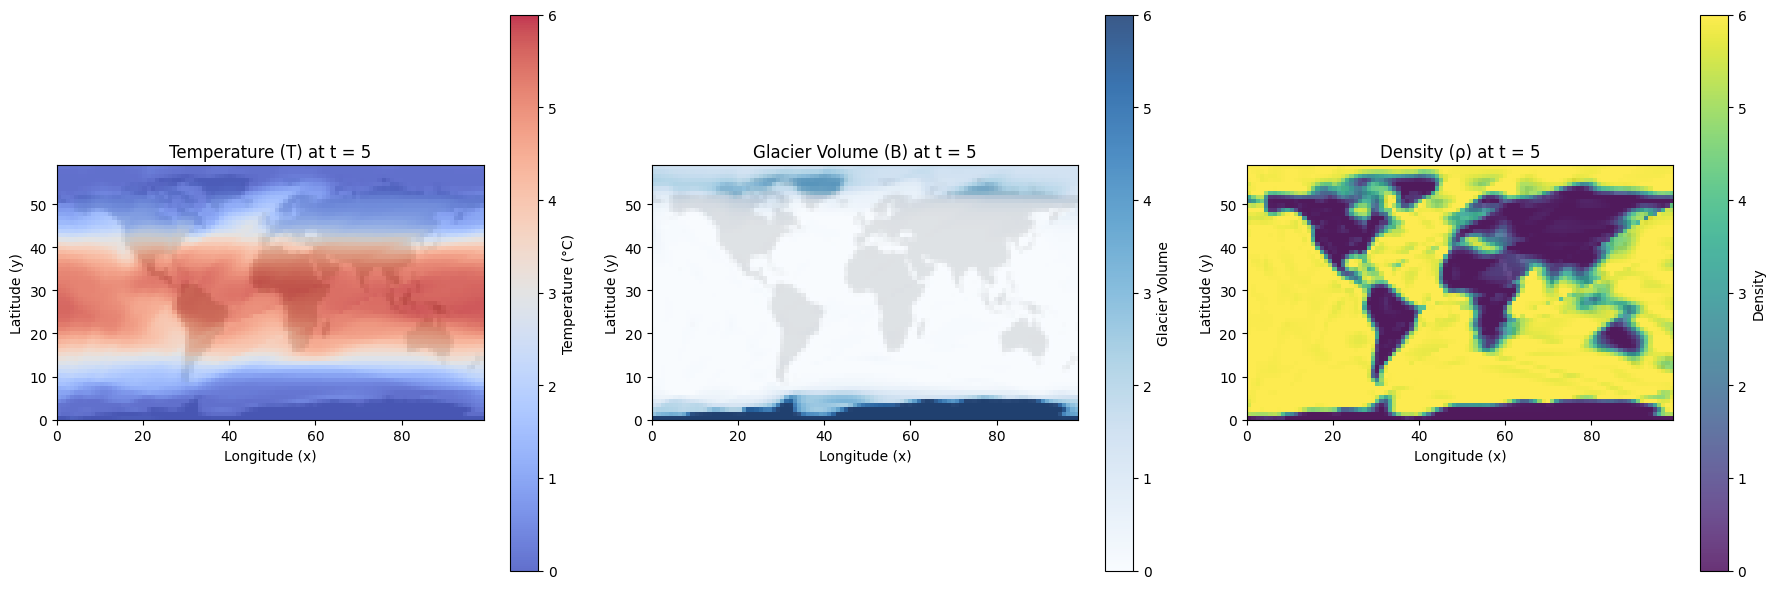

In [68]:
visualize_at_t_with_map(params, t=5, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

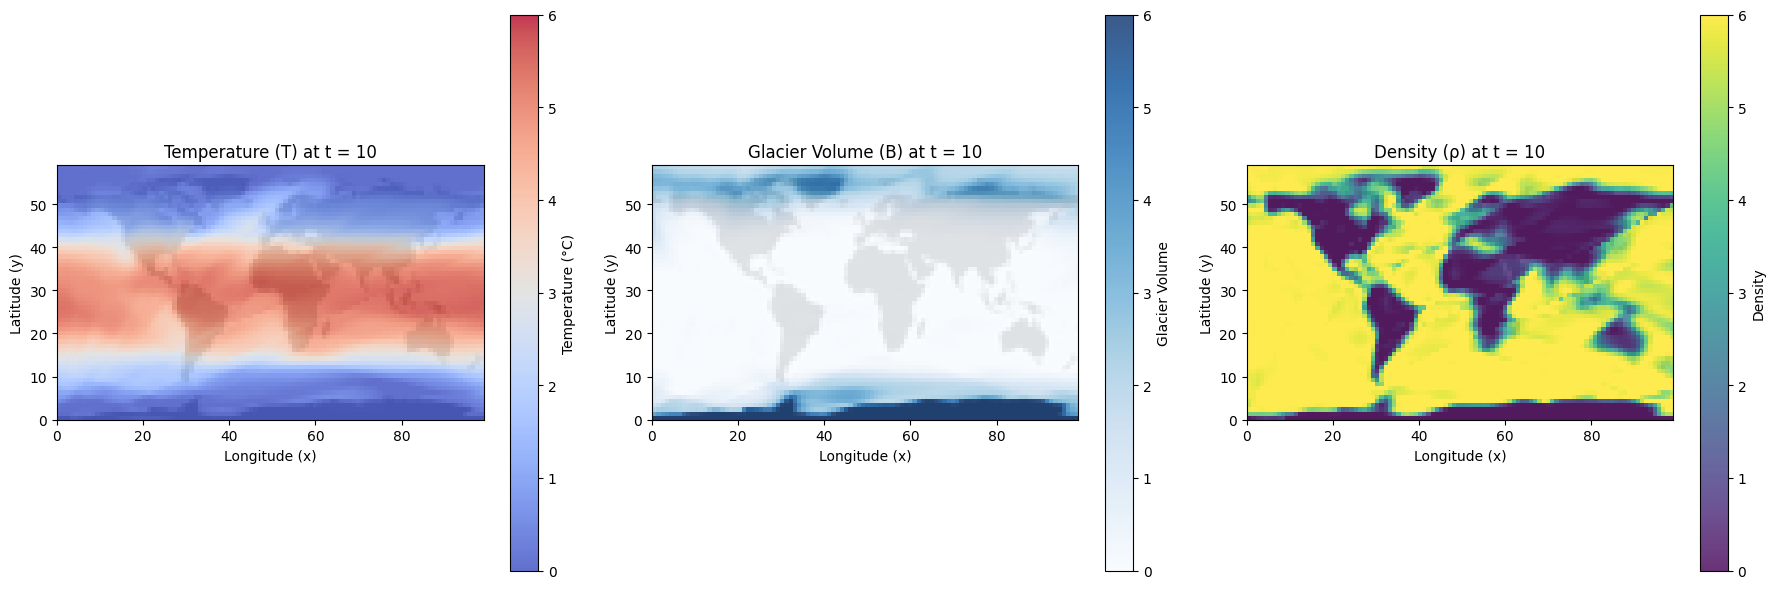

In [69]:
visualize_at_t_with_map(params, t=10, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

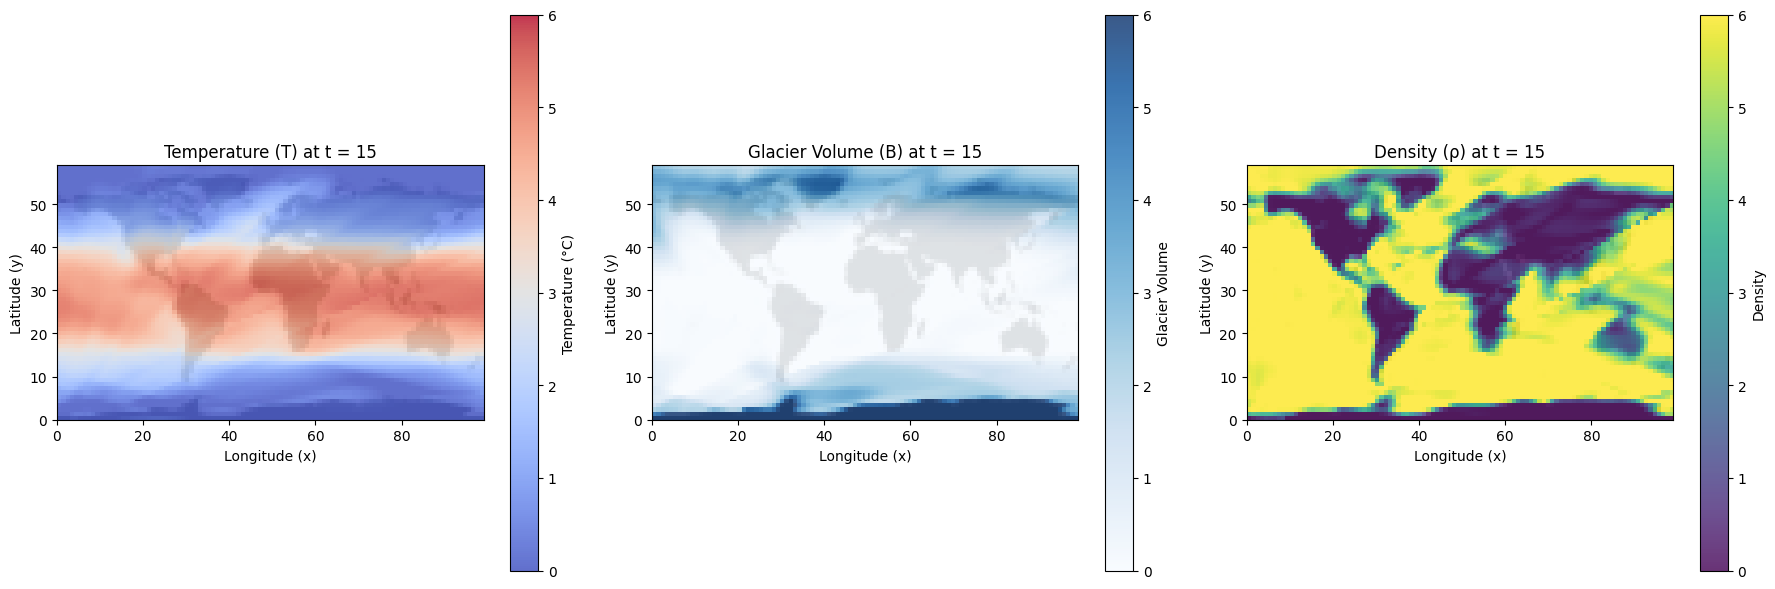

In [70]:
visualize_at_t_with_map(params, t=15, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

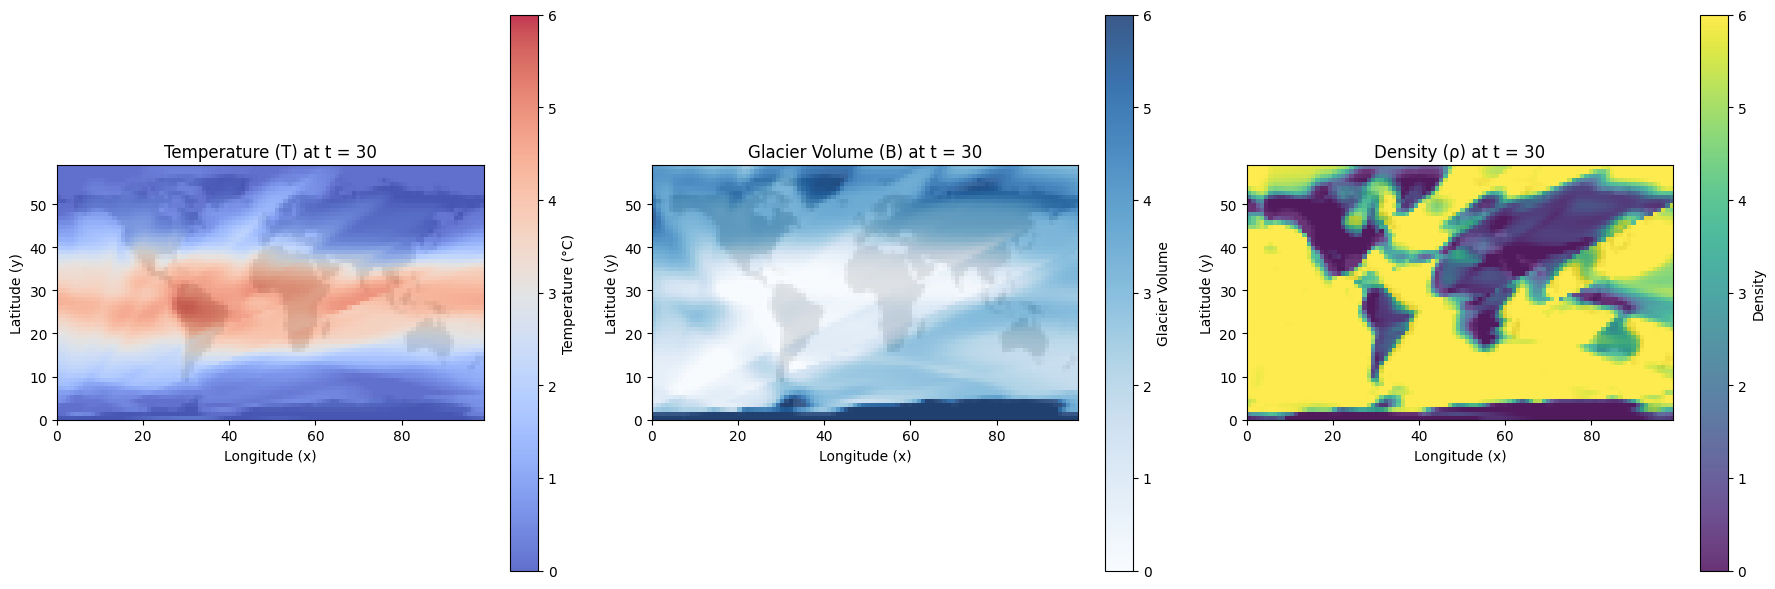

In [71]:
visualize_at_t_with_map(params, t=30, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

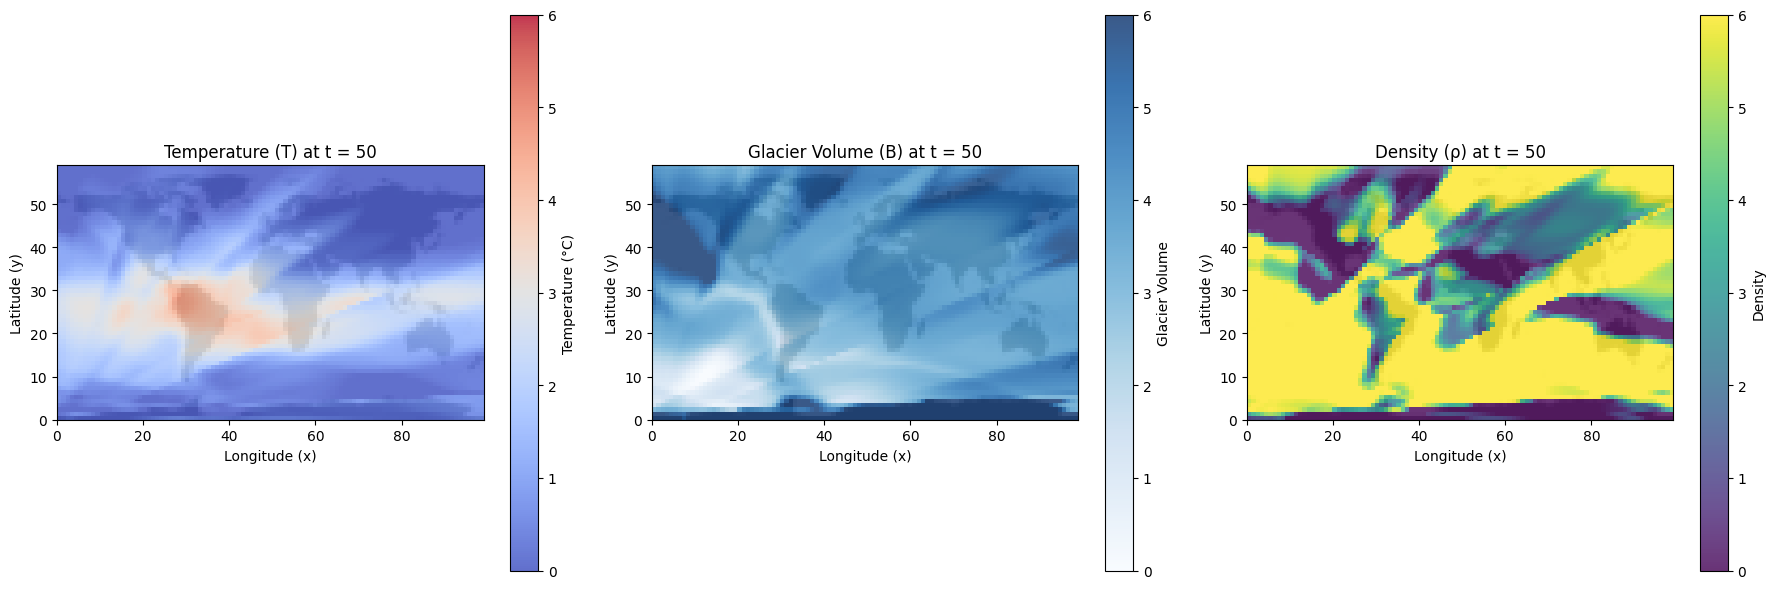

In [72]:
visualize_at_t_with_map(params, t=50, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

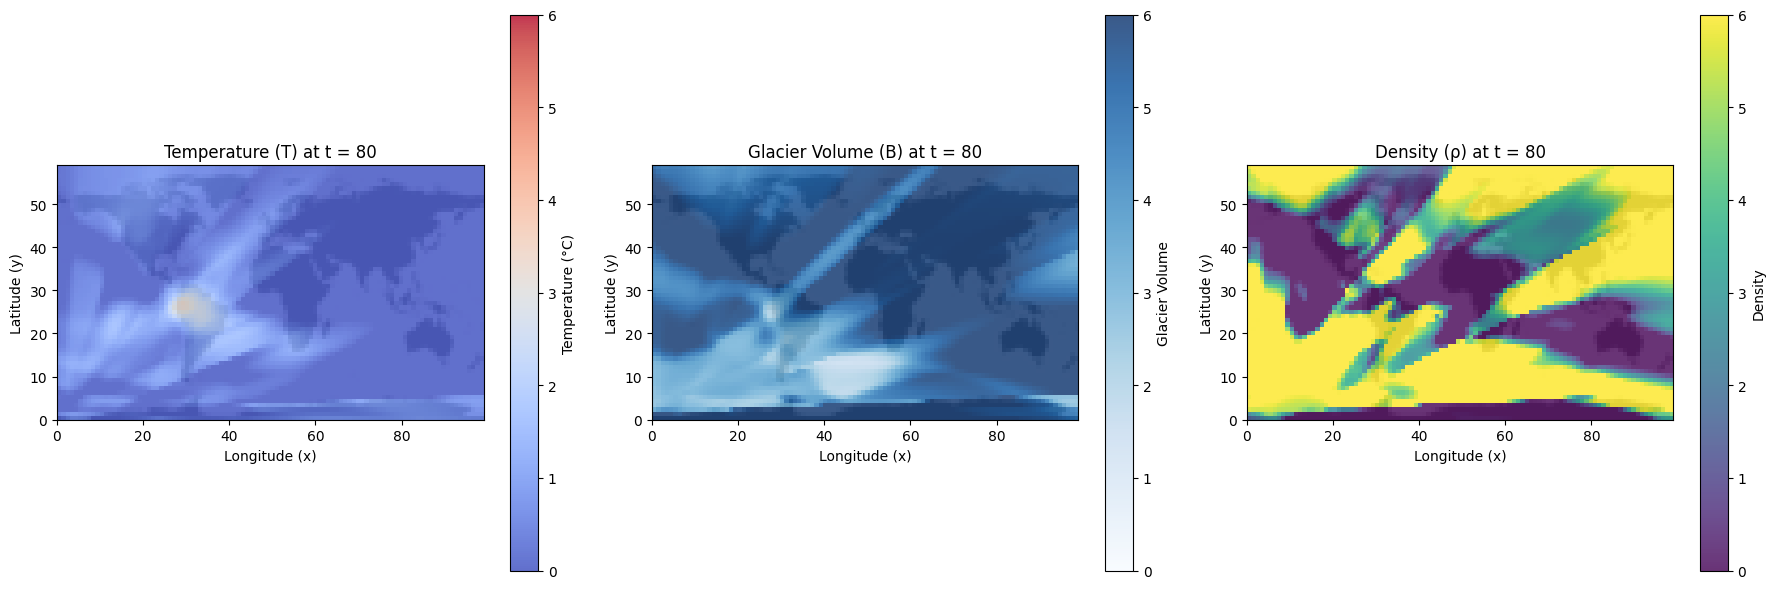

In [73]:
visualize_at_t_with_map(params, t=80, rows=60, cols=100, x_coords=x_coords, y_coords=y_coords, map_path=image_path)

In [74]:
import matplotlib.animation as animation

# 애니메이션 함수 정의
def create_animation_with_map(params, rows, cols, x_coords, y_coords, t_range, save_path, map_path):
    """
    대륙 사진과 함께 온도(T)와 빙하량(B)의 변화를 애니메이션으로 시각화.
    """
    # Load, flip, and resize the world map
    world_map = Image.open(map_path).convert("RGB")
    world_map = world_map.transpose(Image.FLIP_TOP_BOTTOM)  # Flip the image vertically
    world_map = world_map.resize((cols, rows))  # Resize to match data dimensions
    world_map_array = np.array(world_map)

    # Create a figure with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    vmin, vmax = 0, 6  # 색상 범위 고정

    # 초기 상태 시각화를 위한 설정
    axs[0].imshow(world_map_array, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                  origin='lower', alpha=0.5)  # 희미한 지도 배경
    im1 = axs[0].imshow(np.zeros((rows, cols)), extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                        origin='lower', cmap='coolwarm', alpha=0.8, vmin=vmin, vmax=vmax)
    axs[0].set_title("Temperature (T)")
    axs[0].set_xlabel("Longitude (x)")
    axs[0].set_ylabel("Latitude (y)")
    fig.colorbar(im1, ax=axs[0], orientation='vertical', label='Temperature (°C)')

    axs[1].imshow(world_map_array, extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                  origin='lower', alpha=0.5)  # 희미한 지도 배경
    im2 = axs[1].imshow(np.zeros((rows, cols)), extent=[x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]],
                        origin='lower', cmap='Blues', alpha=0.8, vmin=vmin, vmax=vmax)
    axs[1].set_title("Glacier Volume (B)")
    axs[1].set_xlabel("Longitude (x)")
    axs[1].set_ylabel("Latitude (y)")
    fig.colorbar(im2, ax=axs[1], orientation='vertical', label='Glacier Volume')

    plt.tight_layout()

    def update(frame):
        t = t_range[frame]
        T_matrix, B_matrix, _ = predict_variables_at_t(params, t, rows, cols, x_coords, y_coords)

        im1.set_data(T_matrix)
        im2.set_data(B_matrix)

        axs[0].set_title(f"Temperature (T) at t = {t}")
        axs[1].set_title(f"Glacier Volume (B) at t = {t}")

        return im1, im2

    # 애니메이션 생성
    ani = animation.FuncAnimation(fig, update, frames=len(t_range), interval=200, blit=True)

    # 애니메이션 저장
    ani.save(save_path, writer='ffmpeg')
    print(f"Animation saved at {save_path}")

Animation saved at 실제데이터_결과2.mp4


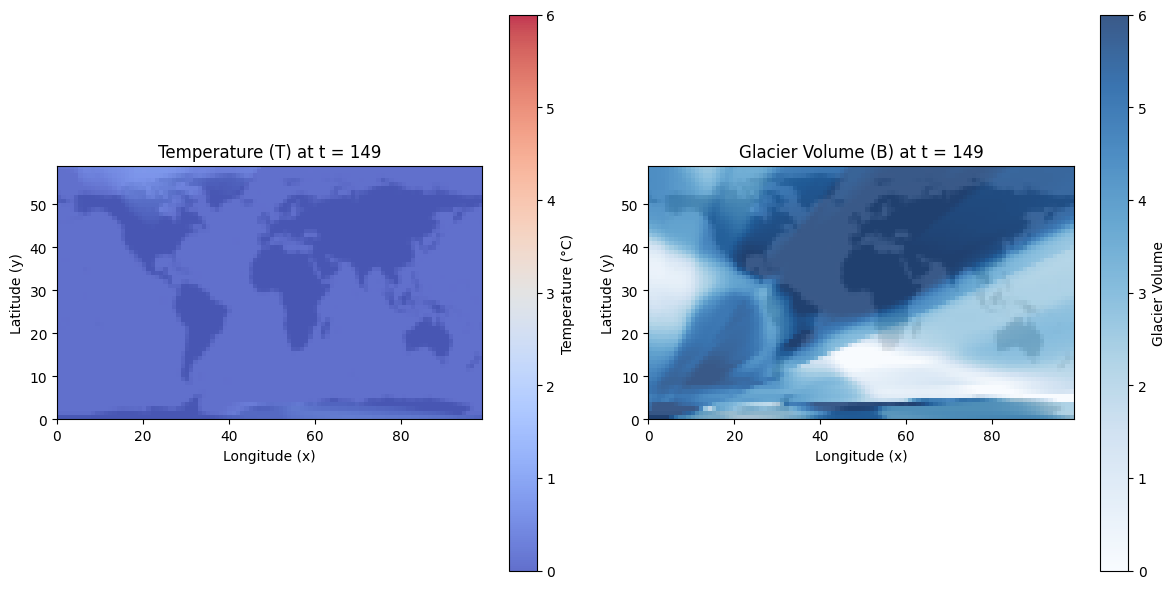

In [78]:
# t=0부터 80까지 1 간격으로 설정
# t_range = np.arange(0, 150, 1)

# 애니메이션 생성 및 저장
# save_path = "실제데이터_결과2.mp4"
# create_animation_with_map(params, rows, cols, x_coords, y_coords, t_range, save_path, image_path)